In [1]:
import pandas as pd
import numpy as np
import datetime
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

import plotly.graph_objects as go
import plotly.express as px
import dash
from dash import dcc
from dash import html

import ibmdata

import ruptures as rpt
import matplotlib.pyplot as plt
from random import gauss
import datetime

Dataframes must:
- have a column named "date"
- must be ordered by date column
- must have a column of interest ie. yield, mean, etc. There can't be too many variations for this. Might have to figure out a way to rename the column of interest into a single constant name.


# Example SQL Pull

In [2]:
DAYSBACK = 800
QUERY = f"""
WITH cte AS(
    SELECT LEFT(lot_id,9) AS Lot_id_base, Last_test_date AS date, yield
    FROM DMIW.PTileWaferFact ptwf
    INNER JOIN DMIW_SYSTEMS.TestParm tp ON tp.testparmkey = ptwf.testparmkey
    INNER JOIN DMIW_SYSTEMS.TestedWafer tw ON tw.testedWaferKey = ptwf.testedWaferKey
    WHERE Last_test_date >= (current date - {DAYSBACK} days) 
        AND Tech_id = '5H 14HP'
        AND Level = 'C5'
        AND tw.Calcdefs = 'DI511' 
        AND parm_Label = 'DI51_C5_M7125P125A_ST_A102_4M_Perfect'
        AND weighted_Mean is not null AND abs(weighted_Mean) < 1e25
)
SELECT Lot_id_base, MIN(date) AS date, ROUND(AVG(yield),2) AS Yield
FROM cte
GROUP BY Lot_id_base
ORDER BY date, Lot_id_base
"""
df = ibmdata.isdw.query(QUERY)
df['yield'] = df['yield'].astype(float).round(2)

In [29]:
DAYSBACK = 800
QUERY = f"""
SELECT lot_Id, family_Code,  dcItem_Name as parameter,
    max(measurement_Date) as date,
    avg(dcItem_Value) as mean
FROM DMIW.MeasuredRawFact mrf
INNER JOIN DMIW_SYSPRC.MeasuredParm mp ON mrf.measuredParmKey = mp.measuredParmKey
INNER JOIN DMIW_SYSPRC.MeasuredWafer mw ON mw.measuredWaferKey = mrf.measuredWaferKey
WHERE Measurement_date >= (current date - {DAYSBACK} days) 
    AND Tech_id = '7HPP'
    AND meas_Pd_Id <> '' and dcItem_Value is not null 
    AND ucase(dcItem_Name) not in ('XCOORD', 'YCOORD', 'XSITE', 'YSITE', 'FIELD X', 'FIELD Y', 'SITE X', 'SITE Y', 'SITEID', 'ROW', 'COLUMN') 
    AND ( ucase(rtrim(meas_Pd_Id) || ' ' || dcItem_Name) like '%RX%ACI%CD%' )  
GROUP BY lot_Id, family_Code,  dcItem_Name
ORDER BY max(measurement_Date), lot_id
"""
df = ibmdata.isdw.query(QUERY)

# Load Parms

In [3]:
m5parms = pd.read_csv('./Parms/M5parms.csv', header=None)
fixed_parms = []
for p in list(m5parms[0]):
    fixed_parms.append(p+"_M5")
m5parms[0] = fixed_parms

In [4]:
m1parms = pd.read_csv('./Parms/M1parms.csv', header=None)
fixed_parms = []
for p in list(m1parms[0]):
    fixed_parms.append(p+"_M1")
m1parms[0] = fixed_parms

In [5]:
mfparms = pd.read_csv('./Parms/MFparms.csv', header=None)
fixed_parms = []
for p in list(mfparms[0]):
    fixed_parms.append(p+"_LT")
mfparms[0] = fixed_parms

In [11]:
mfparms[1].unique()

array(['BEOL', 'FEOLMOL_HOL', 'SRAM', 'Device', 'REL'], dtype=object)

# Save plots to pdf

In [15]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('./CPDResults/M5CPDGraphs.pdf')

In [13]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('./CPDResults/M1CPDGraphs.pdf')

In [14]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('./CPDResults/MFCPDGraphs.pdf')

# Object

In [4]:
class cpd:
    def __init__(self):
        self.outputdf = pd.DataFrame(columns=['parameter','lot_id','date'])
    
    def pull_ilt_data(self, PARM, DAYSBACK = 365, fc = ('Q5','Q6','XQ','X2')):
        fc = str(fc)
        QUERY = f"""
        SELECT LEFT(lot_Id,5) AS lot_id, family_Code, MIN(Last_test_date) AS date, tp.parm_Label as parameter, AVG(weighted_Mean) as mean 
        FROM DMIW.PTileWaferFact ptwf
        JOIN DMIW_SYSTEMS.TestParm tp ON tp.testparmkey = ptwf.testparmkey
        JOIN DMIW_SYSTEMS.TestedWafer tw ON tw.testedWaferKey = ptwf.testedWaferKey
        WHERE Last_test_date >= (current date - {DAYSBACK} days)
        AND Tech_id = '7HPP' 
        AND weighted_Mean is not null AND abs(weighted_Mean) < 1e25 
        AND ( tp.parm_Label LIKE '{PARM}' )
        AND family_Code IN '{fc}'
        GROUP BY LEFT(lot_Id,5), family_Code, tp.parm_Label
        ORDER BY MIN(Last_test_date), LEFT(lot_Id,5)
        """
        df = ibmdata.isdw.query(QUERY)
        df['mean'] = df['mean'].astype(float).round(2)
        return df
    
    def change_point_detector(self,pp,df,rbf_pen = 10, TIMEDELAY = 30, var='mean',date='date'):
        #Empty DataFrame
        if df.empty:
            print('The df is empty')
            return
        if len(df) < 5:
            print('Not enough data points')
            return

        # Find change point index
        points = np.array(df[var])
        model="rbf"
        algo = rpt.Pelt(model=model).fit(points)
        result = algo.predict(pen=rbf_pen)

        if len(result) < 2:
            print('No Change Points At All')
            return
        else:
            cp = result[-2]

        #find change point date
        parm_name = df.parameter[0]
        cp_lot = df.iloc[cp]['lot_id']
        cp_date = df.iloc[cp]['date']
        today = datetime.date.today()
        delta = datetime.timedelta(days = TIMEDELAY)
        if today-cp_date < delta:
            # Plot result
            rpt.display(points, result, figsize=(10, 6))
            plt.title('Most recent change point for {} occured on {} with lot {}'.format(parm_name,cp_date,cp_lot))
            print('t')
            plt.savefig(pp, format='pdf',bbox_inches = "tight", pad_inches=0.5)
            plt.close('all')
            self.outputdf = self.outputdf.append(pd.DataFrame([[parm_name,cp_lot,cp_date]],columns=['parameter','lot_id','date']))
            return
        else:
            print("No Recent Change Points")
            return
        
    def ilt_cpd(self,pp,parmlist,rbf_pen = 5, TIMEDELAY = 30, DAYSBACK = 365, fc = ('Q5','Q6','XQ','X2')):
    
        starttime=time.time()
        for p in parmlist:
            df = self.pull_ilt_data(p, DAYSBACK,fc)
            self.change_point_detector(pp,df, TIMEDELAY = TIMEDELAY, rbf_pen = rbf_pen)
        print(time.time()-starttime)
        pp.close()

In [ ]:
%%time
c = cpd()
c.ilt_cpd(pp = pp,parmlist=fixed_parms, rbf_pen = 5, TIMEDELAY= 1000, DAYSBACK  = 800, fc = ('Q6'))

No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
t
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
t
t
No Change Points At All
No Change Points At All
t
t
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
t
t
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
No Change Points At All
t
No Change Points At All
t
t
No Change Points At All
t
No Change Points At All
t
No Change Points At All
No Change Points At All
No Change Points

In [ ]:
c.outputdf.merge(m5parms, left_on='parameter', right_on=0).drop(columns=[0]).rename(columns={1:'category'}).to_csv("~/Desktop/CPD/CPDResults/m5cpd.csv", index=False)

In [10]:
c.outputdf.merge(m1parms, left_on='parameter', right_on=0).drop(columns=[0]).rename(columns={1:'category'}).to_csv("~/Desktop/CPD/CPDResults/m1cpd.csv", index=False)

In [34]:
c.outputdf.merge(mfparms, left_on='parameter', right_on=0).drop(columns=[0]).rename(columns={1:'category'}).to_csv("~/Desktop/CPD/CPDResults/mfcpd.csv", index=False)

# Functions

In [5]:
def pull_data(PARM, DAYSBACK = 365):
    QUERY = f"""
    SELECT lot_Id, family_Code, MIN(Last_test_date) AS date, tp.parm_Label as parameter, AVG(weighted_Mean) as mean 
    FROM DMIW.PTileWaferFact ptwf
    JOIN DMIW_SYSTEMS.TestParm tp ON tp.testparmkey = ptwf.testparmkey
    JOIN DMIW_SYSTEMS.TestedWafer tw ON tw.testedWaferKey = ptwf.testedWaferKey
    WHERE Last_test_date >= (current date - {DAYSBACK} days)
    AND Tech_id = '7HPP' 
    AND weighted_Mean is not null AND abs(weighted_Mean) < 1e25 
    AND ( tp.parm_Label LIKE '{PARM}' )
    AND family_Code IN ('Q5','Q6')
    GROUP BY lot_Id, family_Code, tp.parm_Label
    ORDER BY MIN(Last_test_date), lot_Id
    """
    df = ibmdata.isdw.query(QUERY)
    df['mean'] = df['mean'].astype(float).round(2)
    return df

In [6]:
def change_point_detector(df,rbf_pen = 10,var='mean',date='date'):
    #Empty DataFrame
    if df.empty:
        print('The df is empty')
        return
    
    # Find change point index
    points = np.array(df[var])
    model="rbf"
    algo = rpt.Pelt(model=model).fit(points)
    result = algo.predict(pen=rbf_pen)
    
    if len(result) < 2:
        print('f1')
        return False
    else:
        cp = result[-2]
    
    #find change point date
    parm_name = df.parameter[0]
    cp_lot = df.iloc[cp]['lot_id']
    cp_date = df.iloc[cp]['date']
    today = datetime.date.today()
    delta = datetime.timedelta(days = 1000)
    if today-cp_date < delta:
        # Plot result
        rpt.display(points, result, figsize=(10, 6))
        plt.title('Most recent change point for {} occured on {} with lot {}'.format(parm_name,cp_date,cp_lot))
        print('t')
        plt.savefig(pp, format='pdf',bbox_inches = "tight", pad_inches=0.5)
        plt.close('all')
        return True
    else:
        print("f")
        return False
    
    
# spit out the date and the lot_id of the shift
# spit out trend chart if True

# Analysis

In [16]:
starttime=time.time()
for p in fixed_parms:
    df = pull_data(p, 800)
    change_point_detector(df,rbf_pen = 5)
print(time.time()-starttime)
pp.close()

t
8.970652341842651


# Exploratory Section

In [16]:
points = np.array(df['yield'])

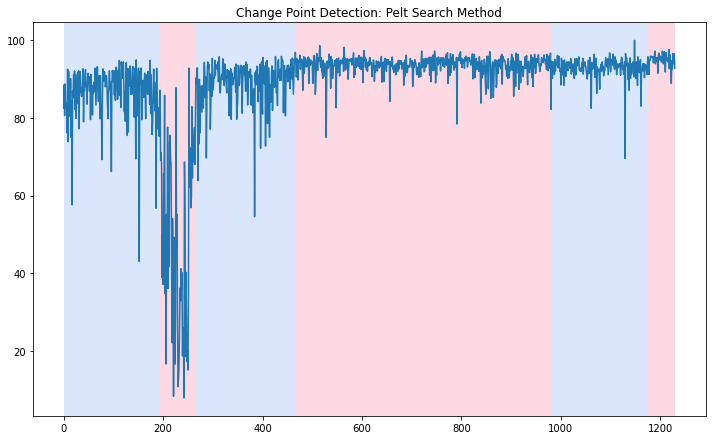

In [18]:
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=3)
fig = rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  

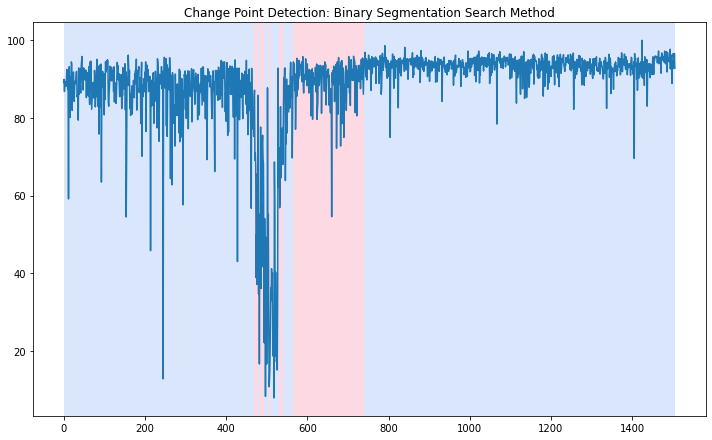

In [11]:
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()

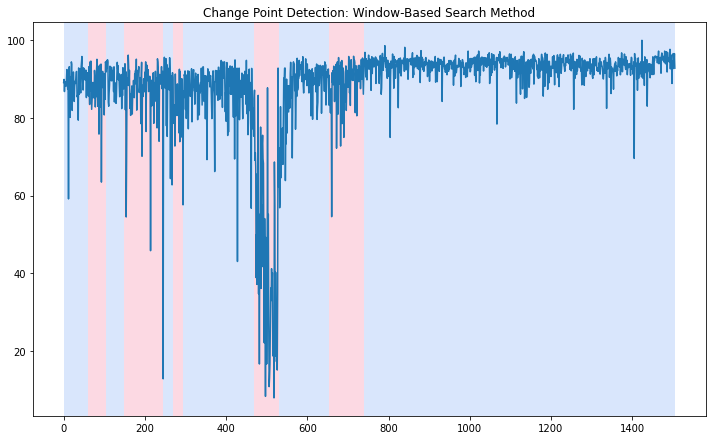

In [12]:
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()

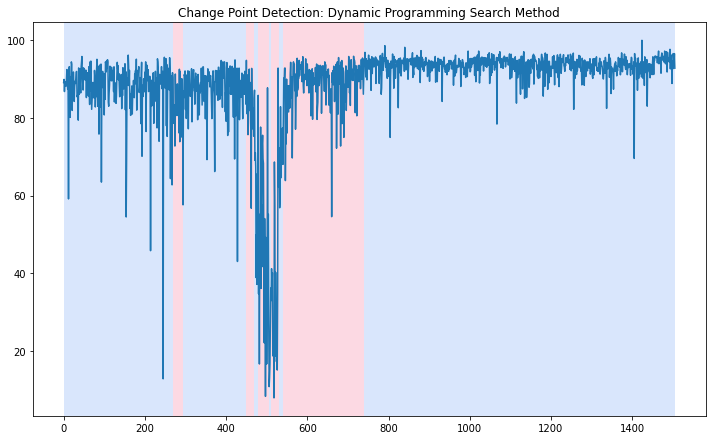

In [13]:
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

## Gate L200

In [594]:
df=pd.read_csv("~/Downloads/L200.csv")

In [595]:
points=np.array(df['Mean'])
points = points[points<10000]

In [606]:
points = np.append(points,gauss(2000,2.4))
#points = np.append(points,gauss(75,8))

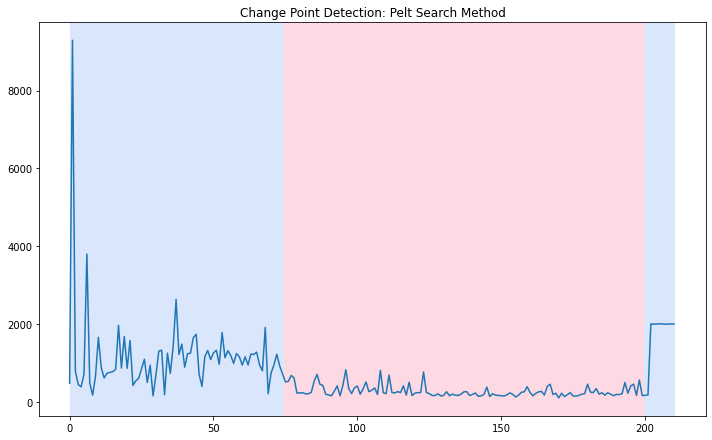

In [607]:
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  

## Gate Leakage

In [591]:
df=pd.read_csv("~/Downloads/Gate_Lkg.csv")

In [592]:
points=np.array(df['Mean'])

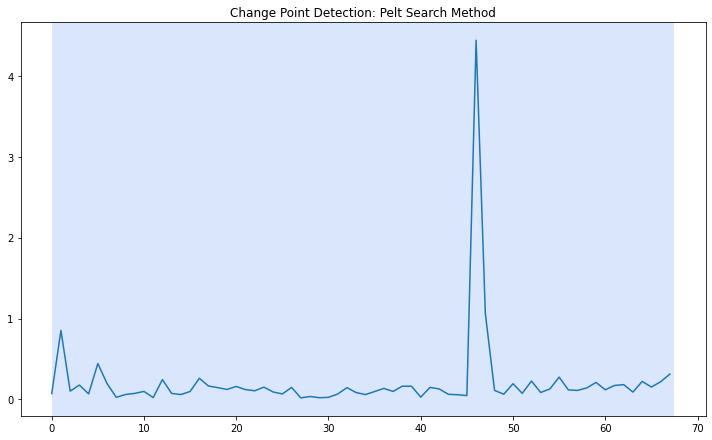

In [593]:
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  

In [23]:
df.to_csv("~/Downloads/example.csv")